In the next notebook we will explore the effects of setting different learning rates for different layers.

The first time i heard about this idea of picking different learning rates for different layers was on the fast-ai course in the context of transer-learning, i.e, using a pre-trained model on a related task. The intuition behind that is pre-trained weights are already good so there's no need to change them a lot. It's still unclear if this true for every transfer learning application, but the same question can be done to the whole deep learning world. It is worth to set differential learning rate per layer and which layer should have higher learning rates?

In [1]:
import numpy as np 
import torch
from torch import nn
from torch import optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision.models as models     
from collections import defaultdict, namedtuple

In [2]:
#set device and seed
device = 'cuda'
torch.manual_seed(1)
torch.cuda.manual_seed(1)
np.random.seed(1)
torch.backends.cudnn.deterministic = True

We we'll work with the cifar10 dataset, which consist in images of 10 different classes. I toke the next code from the pytorch tutorials

In [3]:
transform = transforms.Compose(
    [transforms.Resize(224),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=256,
                                         shuffle=False, num_workers=0)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Our model to use will be a non pre-trained resnet 34. This little function it's for re-download the model and reset its parameters

In [4]:
def getmodel():
    model = models.resnet34(pretrained=False)
    model.fc.out_features = 10
    return model.to(device)

Let's talk about the gradients. It's imposible for me to save them for every minibatch, but you don't want to have access to every specific gradient weight all the time. Instead you want to know how does they behave in general, so, after grabing the gradients at the end of the batch, we'll store some descriptors on the fly. 

We won't compute those statistics for every single layer of the architecture, we'll for group of layers that will be defined below.

In [5]:
class stat:
    '''
    Store a single-valued descriptor of the gradients, as mean or std,
    after every minibatch
    '''
    def __init__(self,fn):
        self.values = defaultdict(list)
        self.fn = fn
        
    def update(self,grads):
        for k,v in grads.items():
            self.values[k].append(self.fn(v))
            
    def plot(self,labels):
        fig, ax = plt.subplots(1,1)
        x = [i for i in range(len(self.values[0]))]
        for k,v in self.values.items():
            ax.plot(x,v,label = labels[k])
        ax.legend()
        plt.show()

In [6]:
class histogram:
    '''
    Store a histogram of the gradients after every minibatch
    '''
    def __init__(self,bins = None, bound = 5e-4):
        self.values = defaultdict(list)
        self.bins = bins
        self.bound = bound
        
    def update(self,grads):
        if not self.bins:
            self.bins = {k: int(1 + np.log(len(v))/np.log(2)) for k,v in grads.items()}
        for k,v in grads.items():
            h = v.histc(bins=self.bins[k],min=-self.bound,max=self.bound).detach().tolist()
            self.values[k].append(h)
            
    def plot(self,labels,**kwargs):
        rows, cols = len(self.values)//2, 2
        fig, axs = plt.subplots(rows,cols,figsize = (15,5))
        axs = axs.flatten()
        fig.patch.set_facecolor('w')
        for (k,v),ax in zip(self.values.items(),axs):
            ax.imshow(np.array(self.values[k]).T,extent = (0,200,-15,15),**kwargs)
            ax.set_title(labels[k])
            ax.set_yticklabels('')
        fig.suptitle('Gradients Histograms over one epoch')
        plt.show()

The way we are going to group the layers it's quite arbitrary and simple. All batchnorm layers are togheter, convolutional layers with the same kernel size get in the same group and finally the last linear layer alone.

In [7]:
class modelgrads:
    '''
    Main module. Get the gradients, update the stats, and it had some 
    other utility functions
    
    model: a torch resnet
    stats: a list of objects with an update method implemented 
    '''
    def __init__(self,model,stats=None):
        self.model = model
        self.stats = stats
        self._set_groups()
        
    def layers(self): 
        for m in self.model.modules():
            if hasattr(m,'weight'):
                yield m
        
    def _set_groups(self):
        layer_type = defaultdict(int,{nn.Linear: 1, nn.Conv2d: 2}) 
        for m in self.layers():
            setattr(m,'group',layer_type[type(m)])  
            if isinstance(m,nn.Conv2d) and m.in_channels != m.out_channels and m.kernel_size == (1,1):
                layer_type[nn.Conv2d] += 1
        self._nconv = layer_type[nn.Conv2d]
    
    def layer_groups(self):
        layer_groups = defaultdict(list)
        for m in self.layers(): layer_groups[m.group].append(m)
        return layer_groups
    
    def labels(self):
        non_conv = {0: 'BatchNorm Layers', 1: 'Linear Layers'}
        conv = {k: f'Conv Layer {k-1}' for k in range(2,self._nconv+1)}
        return {**non_conv,**conv}
        
    def _get_grads(self):
        grads = defaultdict(torch.cuda.FloatTensor)
        for m in self.layers(): 
            grads[m.group] = torch.cat((grads[m.group], m.weight.grad.flatten()))
        return grads

    def update_stats(self):
        grads = self._get_grads()
        for stat in self.stats:
            stat.update(grads)

Next we have the training loop. It's nothing special, it just have a call back to the update method.

In [8]:
def train_loop(model, optimizer, loss_fn, epochs, grads=None):
    
    for _ in range(epochs):
        model.train()
        current = 0
        for img, lab in trainloader:
            optimizer.zero_grad()
            out = model(img.float().to(device))
            loss = loss_fn(out, lab.cuda().to(device))
            loss.backward()
            optimizer.step()
            current += loss.item()
            if grads:
                grads.update_stats()
                
        train_loss = current / len(trainloader)
                
        with torch.no_grad():
            current, acc = 0, 0
            model.eval()
            for img, lab in testloader:
                out  = model(img.float().to(device))
                loss = loss_fn(out, lab.to(device))
                current += loss.item() 
                _, pred = nn.Softmax(-1)(out).max(-1)
                acc += (pred == lab.cuda()).sum().item()

            valid_loss = current / len(testloader)
            accuracy   = 100 * acc / len(testset)

        print(f'Train loss: {train_loss:.2f}, Validation loss: {valid_loss:.2f}, Accuracy: {accuracy}')

In [9]:
resnet = getmodel()

In [10]:
absmean = stat(fn = lambda v: v.abs().mean().detach().item())
mean = stat(fn = lambda v: v.mean().detach().item())
std = stat(fn = lambda v: v.std().detach().item())
hist = histogram()

In [11]:
resnet_grads = modelgrads(resnet, stats = [absmean, mean, std, hist])

In [12]:
optimizer = optim.Adam(resnet.parameters(), lr =1e-3)
loss_fn = nn.CrossEntropyLoss()

We will train the model just for one epoch

In [13]:
train_loop(model = resnet, optimizer = optimizer, loss_fn = loss_fn, epochs = 1, grads = resnet_grads)

Train loss: 1.60, Validation loss: 1.39, Accuracy: 51.42


In [14]:
labels = resnet_grads.labels()

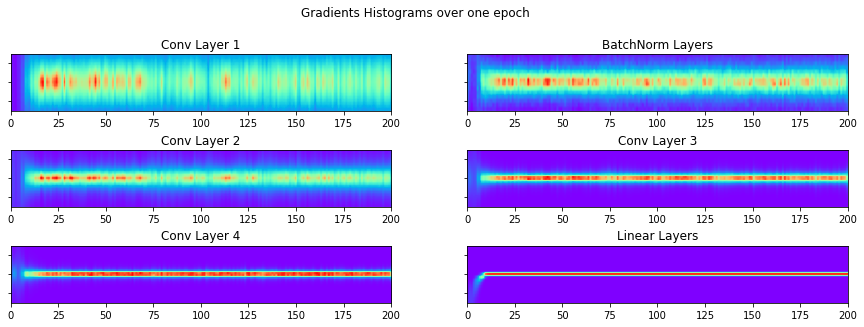

In [15]:
hist.plot(labels, cmap = 'rainbow')

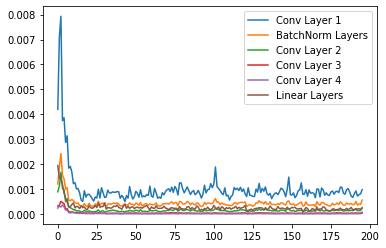

In [16]:
absmean.plot(labels)

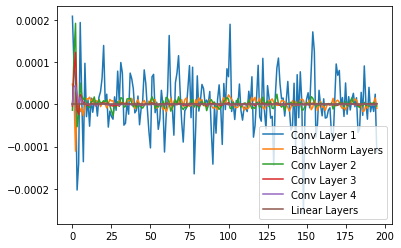

In [17]:
mean.plot(labels)

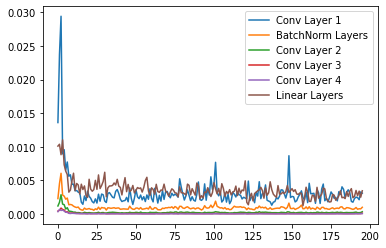

In [18]:
std.plot(labels)

Looking at the results, it's clear that as we go deeper in the net the gradients get smaller and smaller. The gradients of the last group of the final linear layer are almost zero after a few batches. To be honest, to this point I really thought layers near the input should have lower gradients because of the chain rule (backpropagation).

Say $L$ is the loss function; $l_1,l_2$ are the two last layers which depends on the parameters $\alpha,\beta$ respectively and $v = l_1(\alpha,u), w = l_2(\beta,v)$. Then we have

\begin{align*}
\frac{\partial L}{\partial \beta} =  \frac{\partial L}{\partial w}\frac{\partial w}{\partial \beta}\\
\frac{\partial L}{\partial \alpha} =  \frac{\partial L}{\partial w}\frac{\partial w}{\partial v}\frac{\partial v}{\partial \alpha}
\end{align*}

As we go more layers back, more therms appear into the product above. If they are small (less than one), the product goes to zero. Doesn't make much sense when we look at the plots so we can only expect at some point those derivatives to be greater than one. Take a moment to think about what they are: functions on the activations and weights. Activations (we hope) have mean zero and deviation one. Weights, according to torch docs are drawn from 

\begin{align*}
\mathcal{U}(-\sqrt{\nu},\sqrt{\nu})\\
\nu = \frac{1}{C_{in}\cdot k^2}\\
\end{align*}

where $C_in$ are the input channels and $k$ the kernel size, so they're small too, at least at the beginning of the training. So what happened here? The gradients functions at some point are huge sums and products and considering at some layers all negative activations are nullified by relu, it makes some sense that those products sum enough to be greater than one.

Anyway, I'm not going to go deeper into this topic, although it seems interesting. Let's move onto the next section.

### Setting the learning rates

We'll set the learning rates in a way that they grow exponentially, starting at the layers near to the input and increasing it as we go to the ones near to the output. 

In [19]:
def optim_diff(layer_groups, lr, cr):
    opt = []
    for k,group in groups.items():
        if k == 1:
            opt.append({'params': [par for l in group for par in l.parameters()], 
                        'lr': 1e-2})
        else:
            opt.append({'params': [par for l in group for par in l.parameters()], 
                        'lr': lr*(1+cr)**(k-1)})  
    return optim.Adam(opt, lr = lr)

We'll train the net with a constant learning rate and with differential learning rates and see which one performs better.

In [20]:
resnet = getmodel()
groups = modelgrads(resnet).layer_groups()
optimizer = optim_diff(groups, 1e-3,.1)
train_loop(model = resnet, optimizer = optimizer, loss_fn = loss_fn, epochs = 5)

Train loss: 1.75, Validation loss: 1.48, Accuracy: 45.33
Train loss: 1.12, Validation loss: 1.04, Accuracy: 63.06
Train loss: 0.83, Validation loss: 1.47, Accuracy: 54.46
Train loss: 0.67, Validation loss: 0.70, Accuracy: 75.6
Train loss: 0.54, Validation loss: 0.65, Accuracy: 77.82


In [21]:
resnet = getmodel()
groups = modelgrads(resnet).layer_groups()
optimizer = optim.Adam(resnet.parameters(), lr =1e-3)
train_loop(model = resnet, optimizer = optimizer, loss_fn = loss_fn, epochs = 5)

Train loss: 1.57, Validation loss: 1.21, Accuracy: 54.86
Train loss: 0.96, Validation loss: 1.10, Accuracy: 62.57
Train loss: 0.70, Validation loss: 1.18, Accuracy: 64.03
Train loss: 0.56, Validation loss: 0.67, Accuracy: 76.87
Train loss: 0.46, Validation loss: 0.69, Accuracy: 76.15


After 5 epochs, I can't say which optimization method performs better. I actually tried with several different increments (5,10,15 and 20\%) and none of those gives a reliable boosting in validation loss or accuracy.  
A few reasons this is happening could be:

* Adam already take into account the gradient size and it doesn't substract the raw gradients 
* The change or increase rate parameter needs to be much more carefully fine tuned, along the learning rate, to really see improvements 

Anyway, it was super interesting to see how the gradients of model evolved during the training. I'm pretty sure this behavior it's the same for all the resnet architectures and it was kind of surprising the deeper layers have smaller gradients. 